# Local Outlier Factor for Credit Card Fraud Detection

## Importing Libraries and Dataset

In [1]:
#importing libraries
import pandas as pd        #for dataframe data structure
import numpy as np         # for numpy arrays and scientific computations

import matplotlib.pyplot as plt      #for data visualization
%matplotlib inline

from sklearn.neighbors import LocalOutlierFactor       #for Local Outlier Factor Model
from sklearn import metrics                            #for evaluation metrics
                                                       
import seaborn as sns                                  #for visualization
from sklearn.preprocessing import StandardScaler       #for Data Preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

In [2]:
from imblearn.over_sampling import SMOTE        

Using TensorFlow backend.


## Data Overview

In [3]:
#importing dataset
df=pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data=df.sample(frac=1,random_state=1)
print(data.shape)

(284807, 31)


In [5]:
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_frac = len(fraud) / float(len(valid))
print(outlier_frac)

print("fraud cases: {}".format(len(fraud)))
print("valid cases: {}".format(len(valid)))

0.0017304750013189597
fraud cases: 492
valid cases: 284315


In [6]:
#Creating predictor and target variables
X=data.copy()
X.drop(['Class'],axis=1,inplace=True)
y=data['Class']

## Data Splitting

In [7]:
#Splitting dataset into Trainset and Testset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (227845, 30)
Number transactions y_train dataset:  (227845,)
Number transactions X_test dataset:  (56962, 30)
Number transactions y_test dataset:  (56962,)


## Data Modeling

In [8]:
lof=LocalOutlierFactor(n_neighbors= 20,  contamination = outlier_frac,novelty=True)

In [9]:
lof.fit(X_train)
scores_pred = lof.negative_outlier_factor_
y_pred=lof.predict(X_test)
## The  prediction value for these models by default give -1 and +1 which needs to be changed to 0 and  1
y_pred[y_pred == 1] =0
y_pred[y_pred == -1] =1    


In [10]:
y_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
scores_pred[0:10]

array([-0.97906414, -1.23295533, -1.05882661, -1.00185324, -1.06958944,
       -1.2796321 , -1.10686473, -1.04731905, -1.21170617, -1.03007765])

In [15]:
E1=(y_pred != y_test).sum()
T1=metrics.accuracy_score(y_test,y_pred)
L1=metrics.log_loss(y_test,y_pred)
F1=metrics.f1_score(y_test,y_pred,average='weighted')
C1=metrics.classification_report(y_test,y_pred)

print("Number of Errors : ",E1)
print("Test Accuracy score : ",T1)
print("Log Loss : ",L1)
print("F1- Score : ",F1)
print("Classification Report : ",C1)


Number of Errors :  184
Test Accuracy score :  0.9967697763421228
Log Loss :  0.11156922195208928
F1- Score :  0.9967199096375808
Classification Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.05      0.05      0.05       100

    accuracy                           1.00     56962
   macro avg       0.53      0.52      0.52     56962
weighted avg       1.00      1.00      1.00     56962



In [16]:
#saving accuracy results
one=pd.DataFrame([E1,T1,L1,F1,1.00,0.05])

## Selecting the best value of n_neighbors

In [17]:
#Finding the best value of C
ns = 40

mean_acc = np.zeros(ns)
std_acc = np.zeros(ns)

for i in range(1,ns):
    #Train Model and Predict  
    lof=LocalOutlierFactor(n_neighbors=i,  contamination = outlier_frac,novelty=True)
    lof.fit(X_train)
    y_pred=lof.predict(X_test)
    y_pred[y_pred == 1] =0
    y_pred[y_pred == -1] =1    
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)
        
    std_acc[i-1]=np.std(y_test==y_pred)/np.sqrt(y_pred.shape[0])

mean_acc

array([0.99638355, 0.99692778, 0.99713844, 0.99708578, 0.99703311,
       0.99685755, 0.99685755, 0.99694533, 0.99691022, 0.99687511,
       0.99682244, 0.99682244, 0.99676978, 0.99675222, 0.99673467,
       0.99662933, 0.99671711, 0.99666444, 0.99673467, 0.99676978,
       0.99680489, 0.99685755, 0.99680489, 0.99675222, 0.99671711,
       0.99676978, 0.99671711, 0.99675222, 0.99682244, 0.99678733,
       0.99680489, 0.99676978, 0.99676978, 0.99676978, 0.99671711,
       0.99662933, 0.99664689, 0.99664689, 0.99669955, 0.        ])

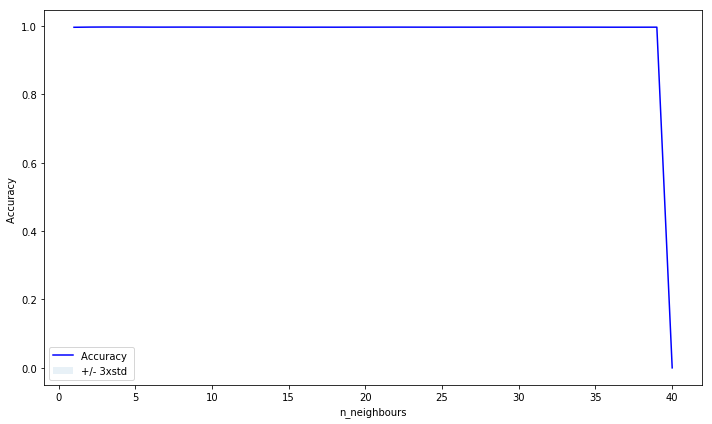

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(1,ns+1),mean_acc,'b')
plt.fill_between(range(1,ns+1),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('n_neighbours')
#plt.xlim(0.001,)
plt.tight_layout()
plt.show()

In [19]:
best_n=35

From the graph we can conclude that all values from 1 to 37 result in the same accuracy. Therefore let us consider n_neighbors=35 as our best value

## Fitting Best Model

In [20]:
best_lof=LocalOutlierFactor(n_neighbors= best_n,  contamination = outlier_frac,novelty=True)

In [21]:
best_lof.fit(X_train)
scores_pred = best_lof.negative_outlier_factor_
y_pred=best_lof.predict(X_test)
## The  prediction value for these models by default give -1 and +1 which needs to be changed to 0 and  1
y_pred[y_pred == 1] =0
y_pred[y_pred == -1] =1  

In [22]:
E2=(y_pred != y_test).sum()
T2=metrics.accuracy_score(y_test,y_pred)
L2=metrics.log_loss(y_test,y_pred)
F2=metrics.f1_score(y_test,y_pred,average='weighted')
C2=metrics.classification_report(y_test,y_pred)

print("Number of Errors : ",E2)
print("Test Accuracy score : ",T2)
print("Log Loss : ",L2)
print("F1- Score : ",F2)
print("Classification Report : ",C2)


Number of Errors :  187
Test Accuracy score :  0.9967171096520487
Log Loss :  0.11338825094663478
F1- Score :  0.9966217345600386
Classification Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.01      0.01      0.01       100

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
#saving accuracy results
two=pd.DataFrame([E2,T2,L2,F2,1.00,0.05,35])

## Final Report

In [25]:
print("=====================  Local Outlier Factor Analysis Report   ======================")
res=pd.concat([two],axis=1)
rows=pd.DataFrame(['No.of Error','Accuracy Score','Log Loss','F1-Score','Class0 Recall','Class1 Recall','n_neighbors'])
res=pd.concat([res,rows],axis=1)
res.columns=['BEST MODEL','Criteria']
res.set_index("Criteria", inplace = True) 
res

=====================  Local Outlier Factor Analysis Report   ======================


,BEST MODEL
Criteria,
No.of Error,187.000000
Accuracy Score,0.996717
Log Loss,0.113388
F1-Score,0.996622
Class0 Recall,1.000000
Class1 Recall,0.050000
n_neighbors,35.000000
